In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras_tuner.tuners import RandomSearch
from tabulate import tabulate

# Installations via pip (usually placed at the beginning of a script or in a requirements.txt file for clarity and best practice)
!pip install keras-tuner --upgrade
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Loading the Dataset**

In [2]:
data = pd.read_csv('Gold Price Dataset.csv')

**Initial Data Look-up**

In [3]:
data_info = data.info()
data_head = data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


**Data Type Conversion and Formatting**

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

def convert_price(value):
    return float(value.replace(',', ''))

for column in ['Price', 'Open', 'High', 'Low']:
    data[column] = data[column].apply(convert_price)

data['Change %'] = data['Change %'].str.rstrip('%').astype(float) / 100

def convert_volume(value):
    if pd.isna(value):
        return None  
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    return float(value)

data['Vol.'] = data['Vol.'].apply(convert_volume)

**Handing Missing Data**

In [5]:
data['Vol.'] = data['Vol.'].ffill()

**Transforming Data**

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by='Date', ascending=True, inplace=True)

In [7]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
2582,2013-01-02,1689.9,1675.8,1695.0,1672.1,60.0,0.0078
2581,2013-01-03,1675.6,1688.0,1689.3,1664.3,190.0,-0.0085
2580,2013-01-04,1649.9,1664.4,1664.4,1630.0,310.0,-0.0153
2579,2013-01-07,1647.2,1657.3,1663.8,1645.3,90.0,-0.0016
2578,2013-01-08,1663.2,1651.5,1662.6,1648.8,130.0,0.0097


**Data Visualization**

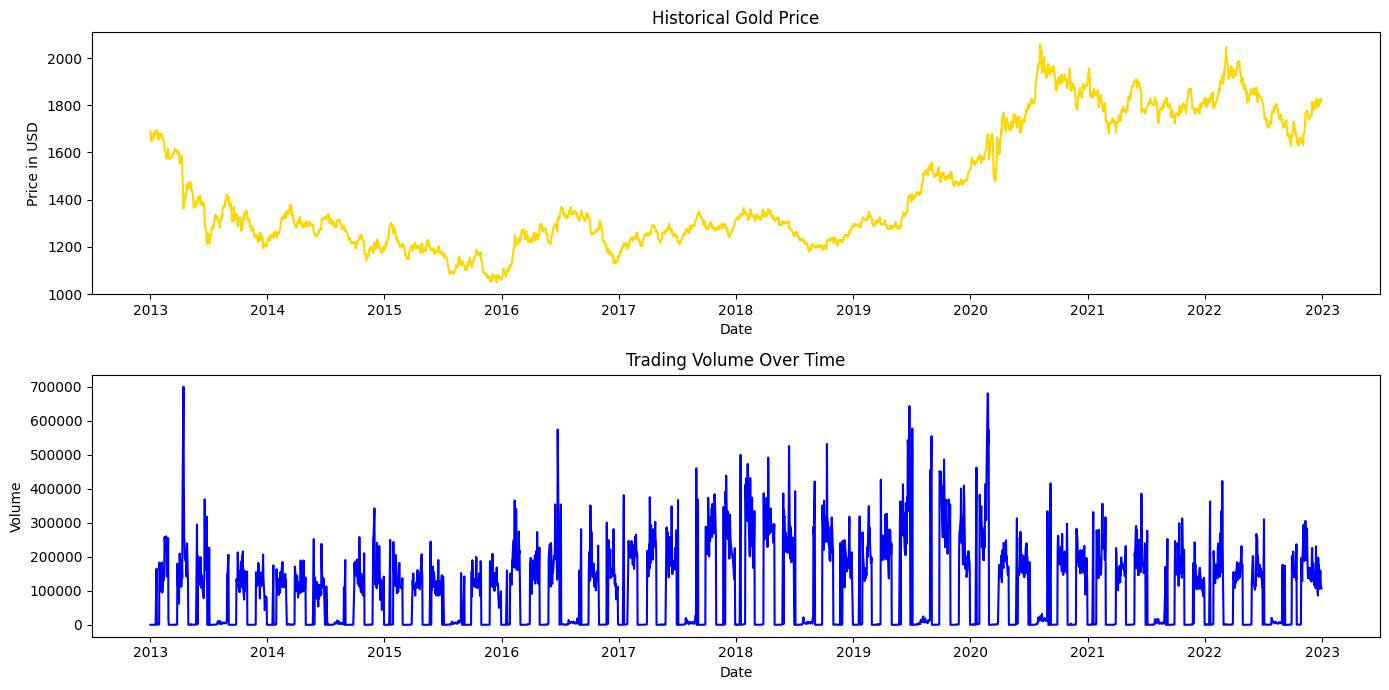

In [8]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)  # This means 2 rows, 1 column, first plot
plt.plot(data['Date'], data['Price'], label='Gold Price', color='gold')
plt.title('Historical Gold Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')

plt.subplot(2, 1, 2)  # This means 2 rows, 1 column, second plot
plt.plot(data['Date'], data['Vol.'], label='Trading Volume', color='blue')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

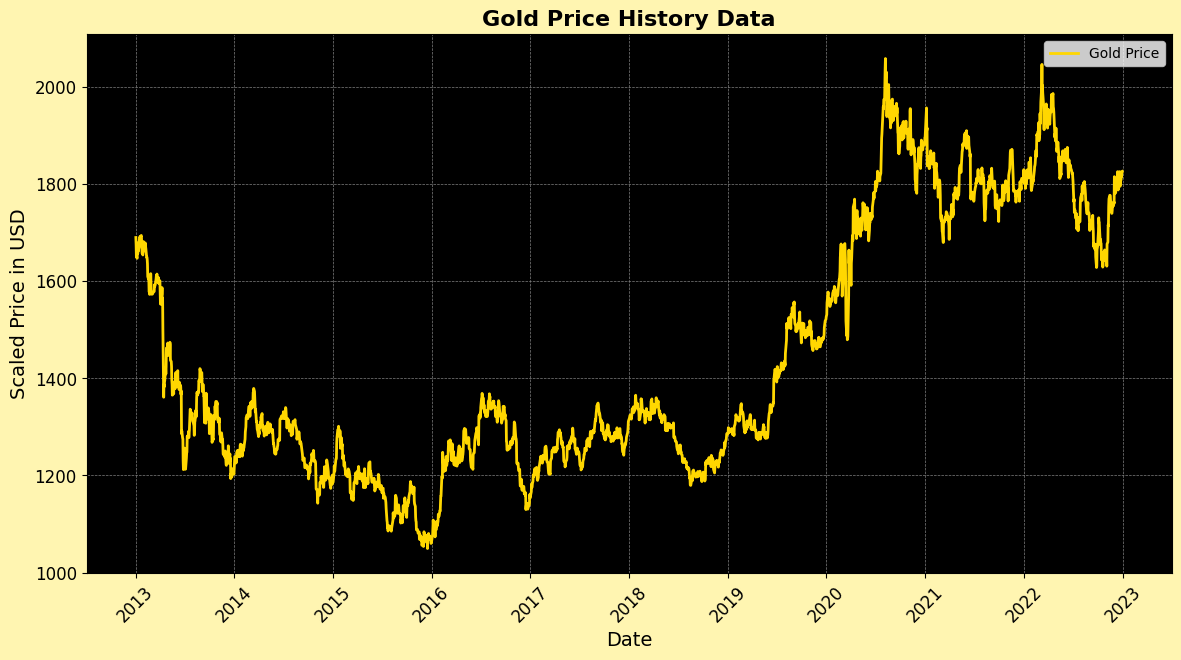

In [9]:
plt.figure(figsize=(14, 7))

plt.plot(data['Date'], data['Price'], label='Gold Price', color='gold', linewidth=2)

plt.title('Gold Price History Data', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Scaled Price in USD', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gca().set_facecolor('black')
plt.gca().figure.set_facecolor((255/255, 223/255, 0/255, 0.3))  # Proper RGBA tuple
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.legend()

plt.show()


**Splitting Data for Test and Train**

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

data.sort_values(by='Date', ascending=True, inplace=True)

cutoff_date = data['Date'].max() - pd.DateOffset(years=1)

train_data = data[data['Date'] <= cutoff_date]
test_data = data[data['Date'] > cutoff_date]

print(f'Training Data Size: {train_data.shape[0]}')
print(f'Testing Data Size: {test_data.shape[0]}')

Training Data Size: 2322
Testing Data Size: 261


**Classification - 1**

*Random Forrest Classifier*

In [18]:


# Step 1: Create lag features and target variable
for lag in range(1, 3):  # Reduced to 2 lag features
    data[f'Lag_{lag}'] = data['Price'].shift(lag)

data.dropna(inplace=True)  # Drop rows with NaN values created by shifts

# Define target variable
data['Target'] = (data['Price'].shift(-1) > data['Price']).astype(int)
data.dropna(inplace=True)  # Drop rows for which the target can't be calculated

# Feature and target definition
features = ['Open', 'High', 'Low', 'Vol.', 'Lag_1', 'Lag_2']
X = data[features]
y = data['Target']

# Step 2: Setup GridSearchCV with TimeSeriesSplit
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10]
}

rf = RandomForestClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)  # Reduced number of splits for TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_
print("Best model parameters:", grid_search.best_params_)
print("Best model score:", grid_search.best_score_)

# Predict using the best model
y_pred = best_model.predict(X)

# Evaluate the model
print("Final Model Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:")
print(classification_report(y, y_pred))

# Step 3: Perform 10-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_list = []

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and predict using the best model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calculate confusion matrix and derived metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Statistic
    hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0

    # Store metrics for the fold
    metrics_list.append({
        'Fold': i,
        'Accuracy': accuracy,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'FPR': fpr,
        'FNR': fnr,
        'TSS': tss,
        'HSS': hss
    })

# Convert metrics to DataFrame and calculate averages
metrics_df = pd.DataFrame(metrics_list)
metrics_avg = metrics_df.mean(numeric_only=True).to_dict()

# Display metrics for each fold and averages
print("K-Fold Metrics Summary:")
print(metrics_df)

# Optional: Save metrics to CSV for further analysis
metrics_df.to_csv('RF_kfold_metrics_summary.csv', index=False)
print("K-Fold metrics saved to 'kfold_metrics_summary.csv'")

print("\nAverage Metrics across 10 folds:")
for metric, value in metrics_avg.items():
    print(f"{metric}: {value:.4f}")


Best model parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best model score: 0.5075117370892018
Final Model Accuracy: 0.9804763764154627
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1265
           1       0.98      0.98      0.98      1296

    accuracy                           0.98      2561
   macro avg       0.98      0.98      0.98      2561
weighted avg       0.98      0.98      0.98      2561

K-Fold Metrics Summary:
   Fold  Accuracy  TP  TN  FP  FN       FPR       FNR       TSS       HSS
0     1  0.529183  64  72  68  53  0.485714  0.452991  0.061294  0.060655
1     2  0.488281  71  54  68  63  0.557377  0.470149 -0.027526 -0.027577
2     3  0.519531  63  70  56  67  0.444444  0.515385  0.040171  0.040117
3     4  0.558594  72  71  53  60  0.427419  0.454545  0.118035  0.117834
4     5  0.460938  63  55  76  62  0.580153  0.496000 -0.076153 -0.075958
5     6  0.5039

**Classification - 2**

*Decision Trees*

In [19]:
for lag in range(1, 5):  # Create lagged features for 4 days
    data[f'Lag_{lag}'] = data['Price'].shift(lag)
data['Rolling_Mean_3'] = data['Price'].rolling(window=3).mean()
data['Rolling_Mean_7'] = data['Price'].rolling(window=7).mean()
data['Volatility_3'] = data['Price'].rolling(window=3).std()
data['Volatility_7'] = data['Price'].rolling(window=7).std()
data['Pct_Change'] = data['Price'].pct_change()

# Drop rows with NaN values due to feature engineering
data.dropna(inplace=True)

# Define target variable with a threshold
price_diff = data['Price'].diff().shift(-1)
data['Target'] = (price_diff > 0.005).astype(int)  # Classify significant upward changes
data.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
            'Rolling_Mean_3', 'Rolling_Mean_7', 'Volatility_3', 'Volatility_7', 'Pct_Change']
X = data[features]
y = data['Target']

# Step 2: Advanced Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'criterion': ['gini', 'entropy']  # Add criterion for splitting
}
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')  # Handle class imbalance
tscv = TimeSeriesSplit(n_splits=5)  # TimeSeriesSplit for time-series cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_
print("Best model parameters:", grid_search.best_params_)
print("Best model score:", grid_search.best_score_)

# Step 3: Evaluate Performance with 10-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_list = []

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and predict using the best model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calculate confusion matrix and derived metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Statistic
    hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0

    # Store metrics for the fold
    metrics_list.append({
        'Fold': i,
        'Accuracy': accuracy,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'FPR': fpr,
        'FNR': fnr,
        'TSS': tss,
        'HSS': hss
    })

# Convert metrics to DataFrame and calculate averages
metrics_df = pd.DataFrame(metrics_list)
metrics_avg = metrics_df.mean(numeric_only=True).to_dict()

# Display metrics for each fold and averages
print("K-Fold Metrics Summary:")
print(metrics_df)

# Optional: Save metrics to CSV for further analysis
metrics_df.to_csv('DT_kfold_metrics_summary.csv', index=False)
print("K-Fold metrics saved to 'kfold_metrics_summary.csv'")

print("\nAverage Metrics across 10 folds:")
for metric, value in metrics_avg.items():
    print(f"{metric}: {value:.4f}")

# Step 4: Evaluate on Entire Dataset
y_pred = best_model.predict(X)
print("\nFinal Model Accuracy on Entire Dataset:", accuracy_score(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))


Best model parameters: {'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best model score: 0.5190588235294118
K-Fold Metrics Summary:
   Fold  Accuracy   TP   TN   FP   FN  FPR  FNR  TSS  HSS
0     1  0.472656    0  121    0  135  0.0  1.0  0.0  0.0
1     2  0.496094    0  127    0  129  0.0  1.0  0.0  0.0
2     3  0.507812  130    0  126    0  1.0  0.0  0.0  0.0
3     4  0.476562    0  122    0  134  0.0  1.0  0.0  0.0
4     5  0.496094  127    0  129    0  1.0  0.0  0.0  0.0
5     6  0.513725  131    0  124    0  1.0  0.0  0.0  0.0
6     7  0.529412    0  135    0  120  0.0  1.0  0.0  0.0
7     8  0.545098  139    0  116    0  1.0  0.0  0.0  0.0
8     9  0.529412    0  135    0  120  0.0  1.0  0.0  0.0
9    10  0.494118    0  126    0  129  0.0  1.0  0.0  0.0
K-Fold metrics saved to 'kfold_metrics_summary.csv'

Average Metrics across 10 folds:
Fold: 5.5000
Accuracy: 0.5061
TP: 52.7000
TN: 76.6000
FP: 49.5000
FN: 76.7000

c:\Users\seera\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seera\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\seera\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

**Classification - 3**

*Support Vector Machines*

In [20]:

# Feature Engineering
for lag in range(1, 5):  # Create lagged features for 4 days
    data[f'Lag_{lag}'] = data['Price'].shift(lag)
data['Rolling_Mean_3'] = data['Price'].rolling(window=3).mean()
data['Rolling_Mean_7'] = data['Price'].rolling(window=7).mean()
data['Volatility_3'] = data['Price'].rolling(window=3).std()
data['Volatility_7'] = data['Price'].rolling(window=7).std()
data['Pct_Change'] = data['Price'].pct_change()

# Drop rows with NaN values due to feature engineering
data.dropna(inplace=True)

# Define target variable
price_diff = data['Price'].diff().shift(-1)
data['Target'] = (price_diff > 0.005).astype(int)  # Classify significant upward changes
data.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
            'Rolling_Mean_3', 'Rolling_Mean_7', 'Volatility_3', 'Volatility_7', 'Pct_Change']
X = data[features]
y = data['Target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 0.1, 0.01],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}
svm = SVC(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best model results
best_model = grid_search.best_estimator_
print("Best model parameters:", grid_search.best_params_)
print("Best model score:", grid_search.best_score_)

# Step 3: Evaluate performance with 10-Fold Cross Validation
metrics_list = []

for i, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    # Splitting the data
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and predict using the best model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calculate confusion matrix and derived metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Statistic
    hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0

    # Store metrics for the fold
    metrics_list.append({
        'Fold': i,
        'Accuracy': accuracy,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'FPR': fpr,
        'FNR': fnr,
        'TSS': tss,
        'HSS': hss
    })

# Convert metrics to DataFrame and calculate averages
metrics_df = pd.DataFrame(metrics_list)
metrics_avg = metrics_df.mean(numeric_only=True).to_dict()

# Display metrics for each fold and averages
print("K-Fold Metrics Summary:")
print(metrics_df)

# Optional: Save metrics to CSV for further analysis
metrics_df.to_csv('SVM_kfold_metrics_summary.csv', index=False)
print("K-Fold metrics saved to 'kfold_metrics_summary.csv'")

print("\nAverage Metrics across 10 folds:")
for metric, value in metrics_avg.items():
    print(f"{metric}: {value:.4f}")

# Final Evaluation on Entire Dataset
y_pred = best_model.predict(X_scaled)
print("\nFinal Model Accuracy on Entire Dataset:", accuracy_score(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))


Best model parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best model score: 0.5182461015902423
K-Fold Metrics Summary:
   Fold  Accuracy  TP  TN  FP  FN       FPR       FNR       TSS       HSS
0     1  0.494118  64  62  62  67  0.500000  0.511450 -0.011450 -0.011438
1     2  0.501961  71  57  78  49  0.577778  0.408333  0.013889  0.013705
2     3  0.525490  71  63  73  48  0.536765  0.403361  0.059874  0.059098
3     4  0.470588  62  58  61  74  0.512605  0.544118 -0.056723 -0.056338
4     5  0.509804  57  73  46  79  0.386555  0.580882  0.032563  0.032008
5     6  0.545098  75  64  67  49  0.511450  0.395161  0.093388  0.093028
6     7  0.549020  75  65  55  60  0.458333  0.444444  0.097222  0.096998
7     8  0.541176  73  65  51  66  0.439655  0.474820  0.085525  0.084619
8     9  0.517647  61  71  58  65  0.449612  0.515873  0.034515  0.034537
9    10  0.527559  70  64  63  57  0.496063  0.448819  0.055118  0.055118
K-Fold metrics saved to 'kfold_metrics_summary.csv'

Average 

**Deep Learning Algorithm**

*Long Short-Term Memory - LSTM*

In [ ]:
for lag in range(1, 5):  # Lagged features
    data[f'Lag_{lag}'] = data['Price'].shift(lag)
data['Rolling_Mean_3'] = data['Price'].rolling(window=3).mean()
data['Rolling_Mean_7'] = data['Price'].rolling(window=7).mean()
data['Volatility_3'] = data['Price'].rolling(window=3).std()
data['Volatility_7'] = data['Price'].rolling(window=7).std()
data.dropna(inplace=True)

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Lag_1', 'Lag_2', 
                                         'Lag_3', 'Lag_4', 'Rolling_Mean_3', 'Rolling_Mean_7', 
                                         'Volatility_3', 'Volatility_7']])

# Prepare sequences for LSTM
sequence_length = 10  # Sequence length as a hyperparameter
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # Use the last `sequence_length` steps
    y.append(data['Price'].iloc[i] > data['Price'].iloc[i-1])  # Binary target: price increase

X, y = np.array(X), np.array(y).astype(int)

# Step 1: Parameter Tuning
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        return_sequences=True),
        input_shape=(X.shape[1], X.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='gold_price_lstm')

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr], verbose=1)

    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Confusion Matrix Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Statistic
    hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0

    metrics_list.append({
        'Fold': fold,
        'Accuracy': accuracy,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'FPR': fpr,
        'FNR': fnr,
        'TSS': tss,
        'HSS': hss
    })

# Step 3: Aggregate Results
metrics_df = pd.DataFrame(metrics_list)
metrics_avg = metrics_df.mean(numeric_only=True).to_dict()

print("K-Fold Metrics Summary:")
print(metrics_df)

metrics_df.to_csv('LSTM_kfold_metrics_summary.csv', index=False)
print("\nMetrics saved to 'kfold_metrics_lstm.csv'")

print("\nAverage Metrics across 10 folds:")
for metric, value in metrics_avg.items():
    print(f"{metric}: {value:.4f}")


Reloading Tuner from lstm_tuning\gold_price_lstm\tuner0.json
Epoch 1/20
72/72 [==============================] - 11s 41ms/step - loss: 0.6998 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - 1s 20ms/step - loss: 0.6938 - accuracy: 0.5055 - val_loss: 0.6934 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - 1s 20ms/step - loss: 0.6923 - accuracy: 0.5265 - val_loss: 0.6933 - val_accuracy: 0.4567 - lr: 0.0010
Epoch 4/20
71/72 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5123
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 [==============================] - 1s 21ms/step - loss: 0.6942 - accuracy: 0.5121 - val_loss: 0.6936 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 0.6919 - accuracy: 0.5191 - val_loss: 0.6934 - val_accuracy: 0.4843 - lr: 5.0000e-04
Epoch

**Comparision of Resuts**

In [ ]:

# File paths for model metrics
file_paths = {
    "Random Forest": "RF_kfold_metrics_summary.csv",
    "Decision Tree": "DT_kfold_metrics_summary.csv",
    "SVM": "SVM_kfold_metrics_summary.csv",
    "LSTM": "LSTM_kfold_metrics_summary.csv"
}

# Metrics to display
selected_metrics = ['Fold', 'Accuracy', 'TP', 'TN', 'FP', 'FN', 'FPR', 'FNR', 'TSS', 'HSS']

# Configurable precision for numeric metrics
decimal_precision = 4


def collect_metrics(model_name, file_path, metrics=selected_metrics):
    """
    Collect fold-wise and average metrics for a given model.
    Args:
        model_name (str): Name of the model.
        file_path (str): Path to the metrics CSV file.
        metrics (list): List of metrics to retain.
    Returns:
        avg_metrics (dict): Average metrics for the model.
        fold_metrics (pd.DataFrame): Fold-wise metrics for the model.
    """
    try:
        metrics_df = pd.read_csv(file_path)
        metrics_df['Model'] = model_name  # Add model name to fold-wise data

        # Calculate average metrics
        avg_metrics = metrics_df[metrics].mean(numeric_only=True).round(decimal_precision).to_dict()
        avg_metrics['Model'] = model_name

        # Retain only required columns
        fold_metrics = metrics_df[metrics + ['Model']]
        return avg_metrics, fold_metrics
    except FileNotFoundError:
        print(f"File not found for {model_name}: {file_path}")
        return None, None
    except Exception as e:
        print(f"Error processing {model_name}: {str(e)}")
        return None, None


def display_table(title, df):
    """
    Display a table with improved formatting.
    Args:
        title (str): Title of the table.
        df (pd.DataFrame): DataFrame to display.
    """
    print(f"\n{title}")
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


# Initialize lists for aggregated and fold-wise metrics
aggregated_results = []
foldwise_results = []

# Collect metrics for each model
for model_name, file_path in file_paths.items():
    avg_metrics, fold_metrics = collect_metrics(model_name, file_path)
    if avg_metrics and fold_metrics is not None:
        aggregated_results.append(avg_metrics)
        foldwise_results.append(fold_metrics)

# Combine aggregated and fold-wise metrics
if aggregated_results and foldwise_results:
    # Aggregated metrics
    comparison_df = pd.DataFrame(aggregated_results).sort_values(by='Accuracy', ascending=False)
    display_table("Model Comparison Results (Average Metrics):", comparison_df)

    # Save aggregated results
    comparison_df.to_csv("model_comparison.csv", index=False)
    print("\nComparison results saved to 'model_comparison.csv'")

    # Fold-wise metrics
    all_folds_df = pd.concat(foldwise_results, ignore_index=True)
    display_table("Fold-Wise Metrics for All Models:", all_folds_df)

    # Save fold-wise results
    all_folds_df.to_csv("fold_wise_metrics.csv", index=False)
    print("\nFold-wise metrics saved to 'fold_wise_metrics.csv'")

    # Optional: Save formatted tables as plain text files
    with open("model_comparison.txt", "w") as f:
        f.write(tabulate(comparison_df, headers='keys', tablefmt='pretty', showindex=False))
    with open("fold_wise_metrics.txt", "w") as f:
        f.write(tabulate(all_folds_df, headers='keys', tablefmt='pretty', showindex=False))
    print("\nFormatted tables saved as text files.")
else:
    print("\nNo results to display. Ensure all files are available and correctly formatted.")



Model Comparison Results (Average Metrics):
+------+----------+------+------+------+------+--------+--------+--------+--------+---------------+
| Fold | Accuracy |  TP  |  TN  |  FP  |  FN  |  FPR   |  FNR   |  TSS   |  HSS   |     Model     |
+------+----------+------+------+------+------+--------+--------+--------+--------+---------------+
| 5.5  |  0.5338  | 62.4 | 72.8 | 52.1 | 66.0 | 0.4206 | 0.5171 | 0.0623 | 0.0627 |     LSTM      |
| 5.5  |  0.5182  | 67.9 | 64.2 | 61.4 | 61.4 | 0.4869 | 0.4727 | 0.0404 | 0.0401 |      SVM      |
| 5.5  |  0.5072  | 67.2 | 62.7 | 63.8 | 62.4 | 0.5042 | 0.4815 | 0.0143 | 0.0142 | Random Forest |
| 5.5  |  0.5061  | 52.7 | 76.6 | 49.5 | 76.7 |  0.4   |  0.6   |  0.0   |  0.0   | Decision Tree |
+------+----------+------+------+------+------+--------+--------+--------+--------+---------------+

Comparison results saved to 'model_comparison.csv'

Fold-Wise Metrics for All Models:
+------+--------------------+-----+-----+-----+-----+---------------